In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp, trapezoid, OdeSolution, RK23, quad
from datetime import datetime
import tqdm 

from MCEq.core import MCEqRun
import mceq_config
from MCEq.geometry.density_profiles import EarthsAtmosphere, CorsikaAtmosphere
import crflux.models as crf
from atm import AtmospherefromTemperatureProfile, generate_atmosphere, read_station_data

# Atmospheres from Radiosonde Observations
This notebook uses data available from the [Integrated Global Radiosonde Archive (IGRA)](https://www.ncei.noaa.gov/products/weather-balloon/integrated-global-radiosonde-archive)

## Real Atmospheric Observations
Let's examine some real atmospheric measurements from real radiosondes/rawinsondes. A nice plotter function will come in handy.

In [8]:
def plot_temp_profile(rws):

    plt.figure(figsize=(4, 6))
    for r in rws:
        obs = r.valid
        plt.plot(obs.temperature, obs.gph*0.001, label=str(r.dtime))

    plt.legend(fontsize=8)
    plt.title(r.st_id)
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('Altitude (km)')

### Key West Data
The stations are cyptically coded. Key West is USM00072201, for example. There's a stagion decoder also available on the NCEI site. It seems that the data is segmented into new, for the past 3 years, and prior data.

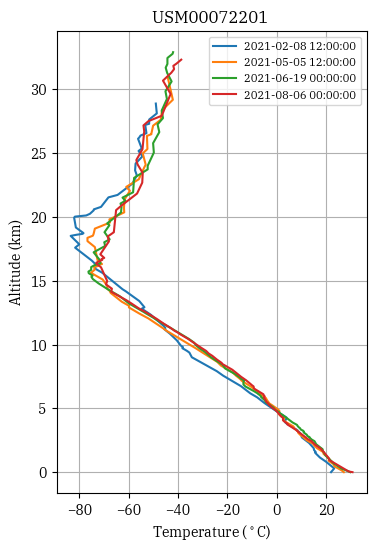

In [9]:
rw_keyw = list(read_station_data('/mnt/w/data/radiosonde/USM00072201-data.txt'))
plot_temp_profile([rw_keyw[i] for i in (77, 250, 340, 440)])

### South Pole data
South Pole (AMUNDSEN SCOTT) is __AYM00089009__. It's notably different from at least Key West as the data is only reported at regular pressure intervals (500, 400, ... etc). I changed around the `Rawinsonde` class to make dealing with missing data less onerous.

The South Pole atmosphere varies quite a bit. Compare this to a tropical atmophere like Jakarta (see below).

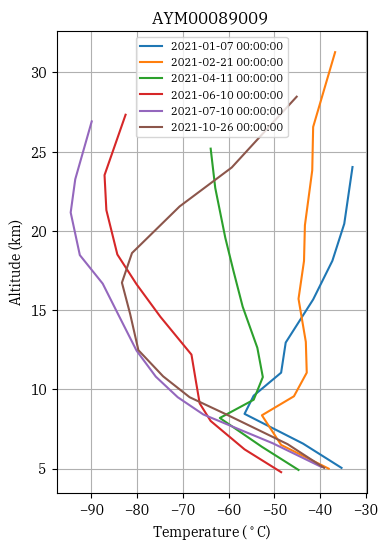

In [11]:
RW89009 = list(read_station_data('/mnt/w/data/radiosonde/AYM00089009-data.txt'))
plot_temp_profile([RW89009[i] for i in (7, 75, 157, 212, 245, 376)])

### Pickle Lake, Canada
Near the southwestern edge of Hudson Bay.

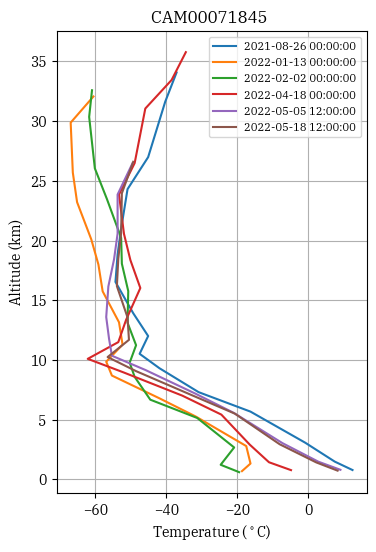

In [14]:
pickle_lake = list(read_station_data('/mnt/w/data/radiosonde/CAM00071845-data.txt'))
plot_temp_profile([pickle_lake[i] for i in (480, 760, 800, 950, 985, 1011)])

### San Diego Miramar
There's a flood advisory for 12/20/2023

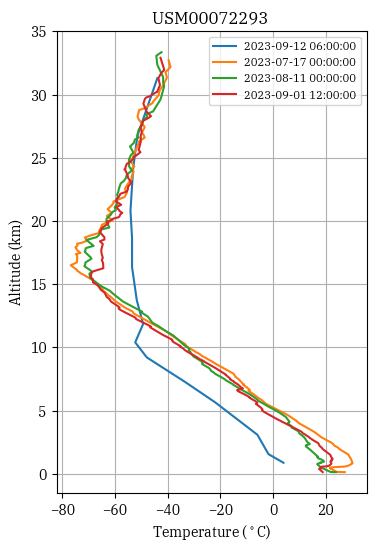

In [16]:
miramar = list(read_station_data('/mnt/w/data/radiosonde/USM00072293-data.txt'))
plt_list = [pickle_lake[-200]]
for i in (-300, -250, -200):
    plt_list.append(miramar[i])
plot_temp_profile(plt_list)

### Jakarta, Indonesia
Tropical, maritime. Wow look at how rock solid that atmosphere it. It never changes!

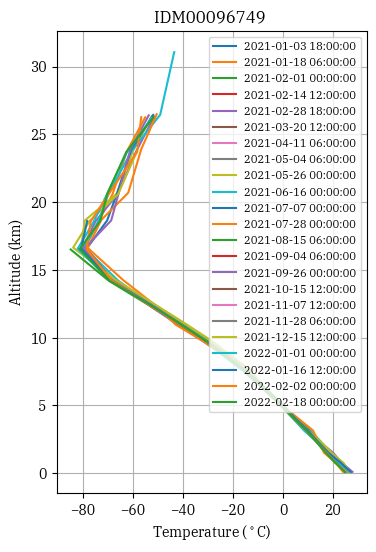

In [17]:
jakarta = list(read_station_data('/mnt/w/data/radiosonde/IDM00096749-data.txt'))
plot_temp_profile([jakarta[i] for i in range(10, 1200, 53)])

## Random Atmosphere Generator
I can generate patterns. Actually I am sure that there's plenty of real data although with generated patterns I can tweak the upper stratosphere and above, too. Plus I can guarantee some level of diversity to handle extreme cases that are rare in real atmospheres. 

### Old Way
I've abandoned the realistic altitude and pressure modeling - as it turns out it is better if I fix these. But I leave the documentation for posterity. I am still using the Weibull distribution to model ground level temperature.

#### Station Altitude
Understand what the actual station altitude distribution looks like. We have the IGRA station list.

Text(0, 0.5, 'Frequency (a.u.)')

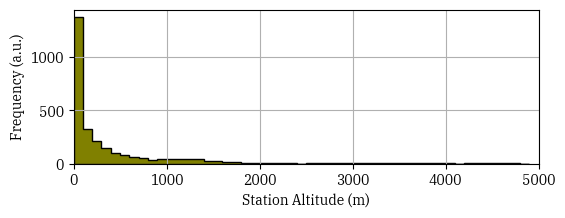

In [80]:
f = open('/mnt/w/data/radiosonde/igra2-station-list.txt', 'rt')
alt = []
for line in f.readlines():
    alt_txt = line[31:37]
    alt.append(float(alt_txt))

plt.figure(figsize=(6,2))
plt.hist(alt, bins=np.arange(0, 5000, 100), log=False, histtype='stepfilled', color='olive', ec='k');
plt.xlim(0, 5000)
plt.xlabel('Station Altitude (m)')
plt.ylabel('Frequency (a.u.)')

Surprisingly there are a lot of stations, airports presumably, at or within 100 m of sea level. There is another population of 1000-2000 m stations, I guess high plains, and then a long tail extending out to nearly 5000 m. Model this with an exponential + gaussian + uniform flat, with probabilities of 88%, 7%, and 5%, respectively.

In [87]:
a0 = np.random.uniform(0, 1, size=10000)
a1 = np.random.exponential(scale=150, size=10000)
a2 = np.random.normal(loc=1250, scale=250, size=10000)
a3 = np.random.uniform(0, 3000, size=10000)
alt = np.where(a0 > 0.95, a3, np.where(a0 > 0.88, a2, a1))

Text(0, 0.5, 'Frequency (a.u.)')

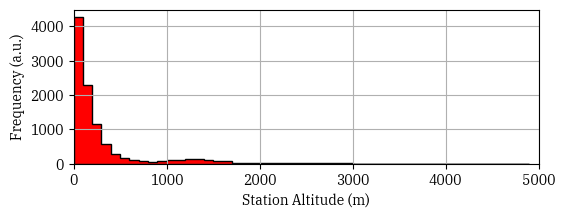

In [88]:
plt.figure(figsize=(6,2))
plt.hist(alt, bins=np.arange(0, 5000, 100), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlim(0, 5000)
plt.xlabel('Station Altitude (m)')
plt.ylabel('Frequency (a.u.)')

#### Choose a Sea Level Pressure

Text(0, 0.5, 'Frequency (a.u.)')

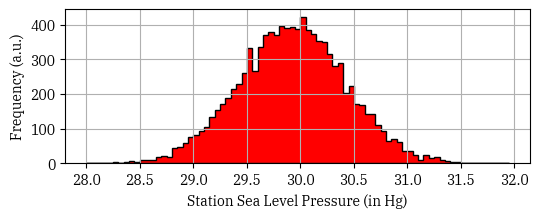

In [94]:
SLP = np.random.normal(loc=29.92, scale=0.5, size=10000)
plt.figure(figsize=(6,2))
plt.hist(SLP, bins=np.arange(28.0,32.0, 0.05), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlabel('Station Sea Level Pressure (in Hg)')
plt.ylabel('Frequency (a.u.)')

Text(0, 0.5, 'Frequency (a.u.)')

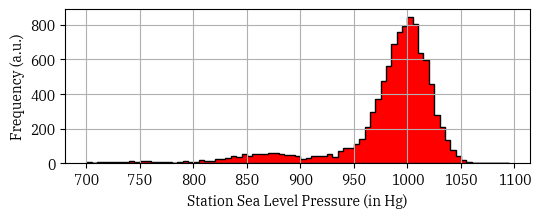

In [101]:
P0 = SLP * 33.87 * ((288.16 - 0.0065*alt) / 288.16)**5.26
plt.figure(figsize=(6,2))
plt.hist(P0, bins=np.arange(700, 1100, 5), log=False, histtype='stepfilled', color='r', ec='k');
plt.xlabel('Station Sea Level Pressure (in Hg)')
plt.ylabel('Frequency (a.u.)')

#### Choose a ground level temperature

(array([   0.,    0.,    0.,    0.,    4.,   19.,   47.,   87.,  157.,
         295.,  511.,  825., 1148., 1498., 1650., 1639., 1225.,  621.,
         228.]),
 array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
          5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.]),
 [<matplotlib.patches.Polygon at 0x7f64efe39890>])

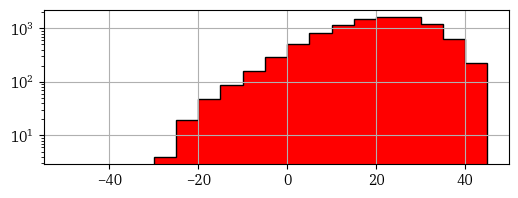

In [11]:
x = np.random.weibull(8, size=10000)*85 - 60
plt.figure(figsize=(6,2))
plt.hist(x, bins=np.arange(-50, 50, 5), histtype='stepfilled', log=True, color='r', ec='k')

#### Temperature lapses
Model as lapse rate layers:

- -0.0065 +/- 0.001 in troposphere (0 AGL up to between 8 km and 15 km MSL)
- 2 layers in tropopause -0.001 to +0.001 (0 to 5 km thick)
- +0.001 to +0.0025 in lower stratosphere (up to 10 km thick)

Text(0, 0.5, 'Altitude (km)')

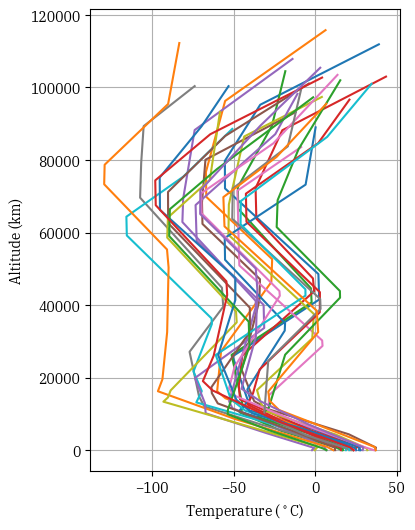

In [4]:
fig = plt.figure(figsize=(4,6))
for i in range(25):
    z, T = simulate_atmosphere()
    plt.plot(T, z)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')

### New Way: Simulator function
Encapsulate all of what was before into a function that directly generates AtmosphreFromTemperatureProfile objects.

Generate 5 random pseudo atmospheres.

In [21]:
a.profile[1]

array([816.50766776,  21.83416719])

(-100.0, 50.0, 0.0, 100000.0)

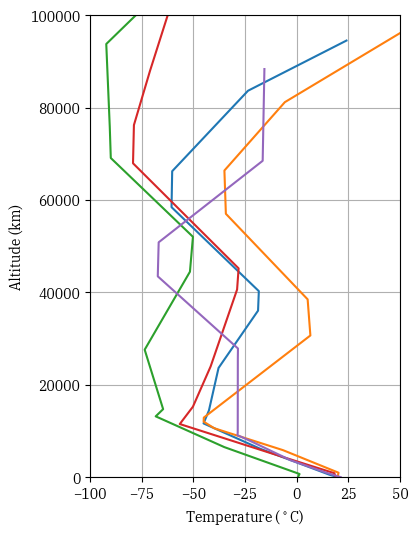

In [2]:
fig = plt.figure(figsize=(4,6))
for i in range(5):
    a = generate_atmosphere()
    z, T = a.profile.T
    plt.plot(T, z)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Altitude (km)')
plt.axis((-100, 50, 0, 100000))

# On to Simulations
This has been moved out of the notebook and into the `scripts/patgen.py` file. Except one point to clean up here and that's to do with using the `int_grid`: I've been using fixed grids over all zenith angles and so off the zenith, I'm sampling _way_ up in the atmosphere.

In [3]:
a = generate_atmosphere()

mceq = MCEqRun(
    interaction_model = 'SIBYLL2.3c',
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    theta_deg = 0.
)

mceq.set_density_model(a)
mceq.solve()


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [8]:
a = generate_atmosphere()
a.h2X((50000, 100000))

array([966.39007083, 910.24472924])